# **Imports**

In [0]:
import torchvision
import torchvision.datasets as dset
import albumentations as A
import numpy as np
import math  
import torch
import cv2
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from matplotlib import pyplot as plt
from google.colab import files
from zipfile import ZipFile as Zip

%matplotlib inline

# **Consts**

In [0]:
MNIST_BATCH_SIZE = 8
FOOD_BATCH_SIZE = 6
FOOD_DATASET_SIZE = 6

ZIP_FILE_NAME = "tray-food-segmentation.zip"
FOOD_DATASET_PATH = "/content/TrayDataset/TrayDataset"

## **Import the numbers' Dataset**

In [524]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving 0_100numbers_ds.py to 0_100numbers_ds (1).py


# **Import kaggle's food dataset**

Install Dependencies

In [409]:
!pip install kaggle

In [0]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"eylonmizrahi","key":"84a76f22f5f6c1a52a652fe9f33b29c8"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d thezaza102/tray-food-segmentation

tray-food-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [541]:
with Zip(ZIP_FILE_NAME, 'r') as z:
  z.extractall()
  print("Done")

del Zip

Done


# **Image Helper Class**

In [0]:
class Image(object):
  def __init__(self, path):
    self.path = path

    self.rgb_image = None
    self.bgr_image = None
    self.gray_image = None


  def read_image(self, return_image = False):
    self.rgb_image = plt.imread(self.path)
    if return_image:
      return self.rgb_image


  def bgr(self, return_image = False):
    self.bgr_image = np.flip(plt.imread(self.path), 2)
    if return_image:
      return self.bgr_image


  def gray(self, return_image = False):
    self.gray_image = cv2.cvtColor(plt.imread(self.path), cv2.COLOR_RGB2GRAY)
    if return_image:
      return self.gray_imagezoom_img


  @staticmethod
  def show(image, title = 'image'):
    if len(image.shape) == 3:
      plt.imshow(image)
    else:
      plt.imshow(image, cmap = 'gray')

    plt.title(title)


  @staticmethod
  def show_all(image_list, title_list):
    assert len(image_list) == len(title_list), "Incompatible lengths of lists!"
    N = len(image_list)
    plt.figure(figsize=[20, 20])

    for i in range(N):
      plt.subplot(1, N, i + 1)
      Image.show(image_list[i], title_list[i])
    
    plt.show()

# **Albumentations Helper Class**

In [0]:
class Albumentations_augmentations:
  def __init__(self):
    self.transform = None
    self.aug_lst = list()

    self.flip = None
    self.blur = None
    self.rotate = None


  def set_flip(self, axis=1, flag=False):
    if flag: # Then the value to set is none
      self.flip = None
      return

    if axis == 0:
      self.flip = A.HorizontalFlip(True)
    elif axis == 1:
      self.flip = A.VerticalFlip(True)


  def set_rotate(self, from_lim=0, to_lim=180, flag=False):
    if flag: # Then the value to set is none
      self.rotate = None
      return

    self.rotate = A.Rotate(limit=(from_lim, to_lim), always_apply=True, border_mode=1)


  def set_blur(self, lim=2, flag=False):
    if flag: # Then the value to set is none
      self.blur = None
      return

    self.blur = A.Blur(blur_limit=lim, always_apply=True)


  def set_transform(self):
    self.aug_lst.clear()

    if self.flip is not None:
      self.aug_lst.append(self.flip)
    if self.blur is not None:
      self.aug_lst.append(self.blur)
    if self.rotate is not None:
      self.aug_lst.append(self.rotate)

    self.transform = A.Compose(np.asarray(self.aug_lst))

  
  def delete_transform(self):
    self.aug_lst.clear()
    self.transform = None

    self.flip = None
    self.blur = None
    self.rotate = None

# **Dataset Class to wrap numbers from 0-100**

In [0]:
class MnistDataset(Dataset):
  def __init__(self, train_images, train_labels, transforms=None, preprocessing=None):
    super(MnistDataset, self).__init__()
    self.x_train = train_images
    self.y_train = train_labels
    self.transforms = transforms
    self.preprocessing = preprocessing

  def __getitem__(self, idx):
    x = self.x_train[idx]
    y = self.y_train[idx]

    if self.transforms:
      x = self.transforms(image = x.numpy())
      x = x['image']

    return x, y

  def __len__(self):
    return len(self.x_train)

# **Image Segmentation Using K-means Algorithm**

In [0]:
def kmeans_segmentation(img):
  # Creates a segmented image by the given image argument, Returns the segmented result

  segmented_img = np.float32(img.reshape((-1, 3)))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  # Hyperparams = 4
  k = 4
  attempts = 10

  ret, labels, center = cv2.kmeans(segmented_img, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
  labels = labels.flatten()
  segmented_img = img.numpy()

  for y in range(segmented_img.shape[0]):
    for x in range(segmented_img.shape[1]):
      for c in range(segmented_img.shape[2]):
        segmented_img[y][x][c] = center[labels[y * segmented_img.shape[1] + x]][c]

  return segmented_img

# **Dataset Class to support unsupervised learning and segmentation**

In [0]:
class Segmentation_Dataset(Dataset):
  def __init__(self, train_images, transforms=None, preprocessing=None):
    super(Segmentation_Dataset, self).__init__()

    self.set_x(train_images[:FOOD_DATASET_SIZE // 2])
    self.set_y()

    self.transforms = transforms
    self.preprocessing = preprocessing


  def set_x(self, train_images):
    # Creates a list of each image example near its segmentation corresponding image, by kmeans algorithm

    self.x_train = list()
    for i in range(len(train_images)):
      self.x_train.append(train_images[i].numpy().copy())
      self.x_train.append(kmeans_segmentation(train_images[i]))


  def clone_images(self, images):
    cloned = list()
    for img in images:
      cloned.append(img.numpy().copy())

    return cloned
    

  def set_y(self):
    self.y_train = list()
    for i in range(len(self.x_train) // 2):
      self.y_train.append("Before-" + str(i))
      self.y_train.append("After-" + str(i))

    self.y_train = np.asarray(self.y_train)


  def __getitem__(self, idx):
    x = self.x_train[idx]
    y = self.y_train[idx]

    if self.transforms:
      x = self.transforms(image = x)
      x = x['image']

    return x, y


  def __len__(self):
    return len(self.x_train)

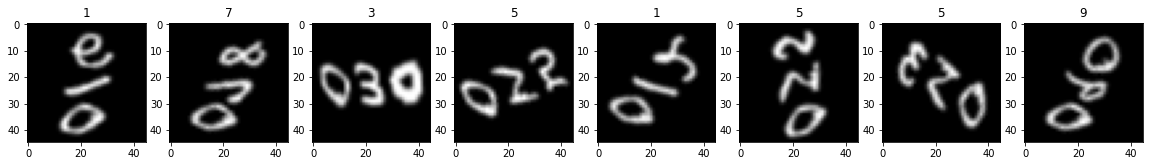

In [547]:
# Creates the transforms through the helper class
alb = Albumentations_augmentations()
alb.set_flip()
alb.set_rotate()
alb.set_blur()
alb.set_transform()

# Creates MNIST Dataset by the set given in mylib imported file
mnist_dataset = MnistDataset(mylib.numbers_examples, mylib.numbers_labels, transforms=alb.transform)

# Creates MNIST Dataloader by the instance of MNIST Dataset above
mnist_dataloader = DataLoader(mnist_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True, num_workers=4)

# Creates an images' batch to iterate and show
next_batch = iter(mnist_dataloader)
batch_imgs, lbls_tensor = next(next_batch)

img_lst = list()
lbl_lst = list()

for img, lbl in zip(batch_imgs, lbls_tensor):
  img_lst.append(img)
  lbl_lst.append(str(lbl)[7:8])

Image.show_all(img_lst, lbl_lst)

# **Reading Food Dataset**

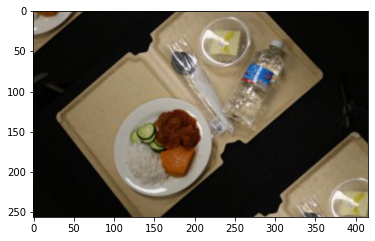

In [548]:
food_train_exmpls = list()
for filename in os.listdir(FOOD_DATASET_PATH + '/XTrain'):
  food_train_exmpls.append(torch.from_numpy(plt.imread(FOOD_DATASET_PATH + '/XTrain/' + filename)))

plt.imshow(food_train_exmpls[0])

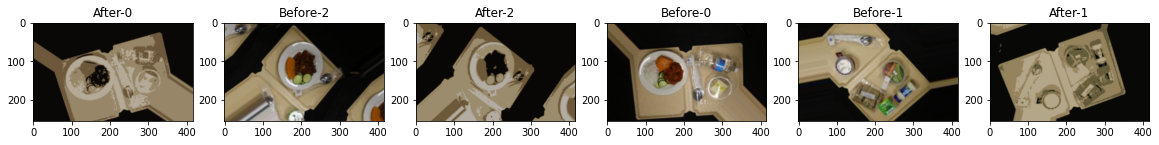

In [549]:
# Creates Food Dataset by the lists food_train_exmpls and food_segmentations
food_dataset = Segmentation_Dataset(food_train_exmpls[:4], transforms=alb.transform)

# Creates MNIST Dataloader by the instance of Food Dataset above
food_dataloader = DataLoader(food_dataset, batch_size=FOOD_BATCH_SIZE, shuffle=True, num_workers=4)

# Creates an images' batch to iterate and show
next_batch = iter(food_dataloader)
batch_imgs, img_lbls = next(next_batch)

img_food_lst = list()
lbl_food_lst = list()

for img, lbl in zip(batch_imgs, img_lbls):
  img_food_lst.append(img)
  lbl_food_lst.append(lbl)

Image.show_all(img_food_lst, lbl_food_lst)

"""Before-i -> same image (no'i) before segmentation. After-i -> same image after segmentation"""
"""BOTH IMAGES BEFORE AND AFTER ARE DIFFERENET BECAUSE THRY PASSED THROUGH RANDOM AUGMENTATION BY ALBUMINATION"""
"""WITHOUT AUGMENTATION IT WOULD SHOW THE SAME IMAGE no'i BUT ONLY WITH THE SEGMENTATION EFFECT"""